In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense,Flatten,  Input, Dropout

In [ ]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip covid19-radiography-database.zip -d /content/data

In [ ]:
base = Xception(weights="imagenet", input_shape =(299,299,3),include_top= False)
for layers in base.layers:
    layers.trainable=False

base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [ ]:
import shutil

# Path to the .ipynb_checkpoints directory
checkpoint_dir = os.path.join(dataset_path, '.ipynb_checkpoints')

# Remove the directory if it exists
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.25,
        horizontal_flip =True
        )
batch_size=32

In [ ]:
train =train_datagen.flow_from_directory(
    "/content/data/COVID-19_Radiography_Dataset",
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')
val =train_datagen.flow_from_directory(
    "/content/data/COVID-19_Radiography_Dataset",
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')
class_names=['covid-19','normal','pneumonia']

Found 11365 images belonging to 3 classes.
Found 3788 images belonging to 3 classes.


In [ ]:
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(12, 4, figsize=(20,80))
    axes = axes.flatten()
    label=0
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.set_title(class_names[np.argmax(labels[label])])
        label=label+1
    plt.show()

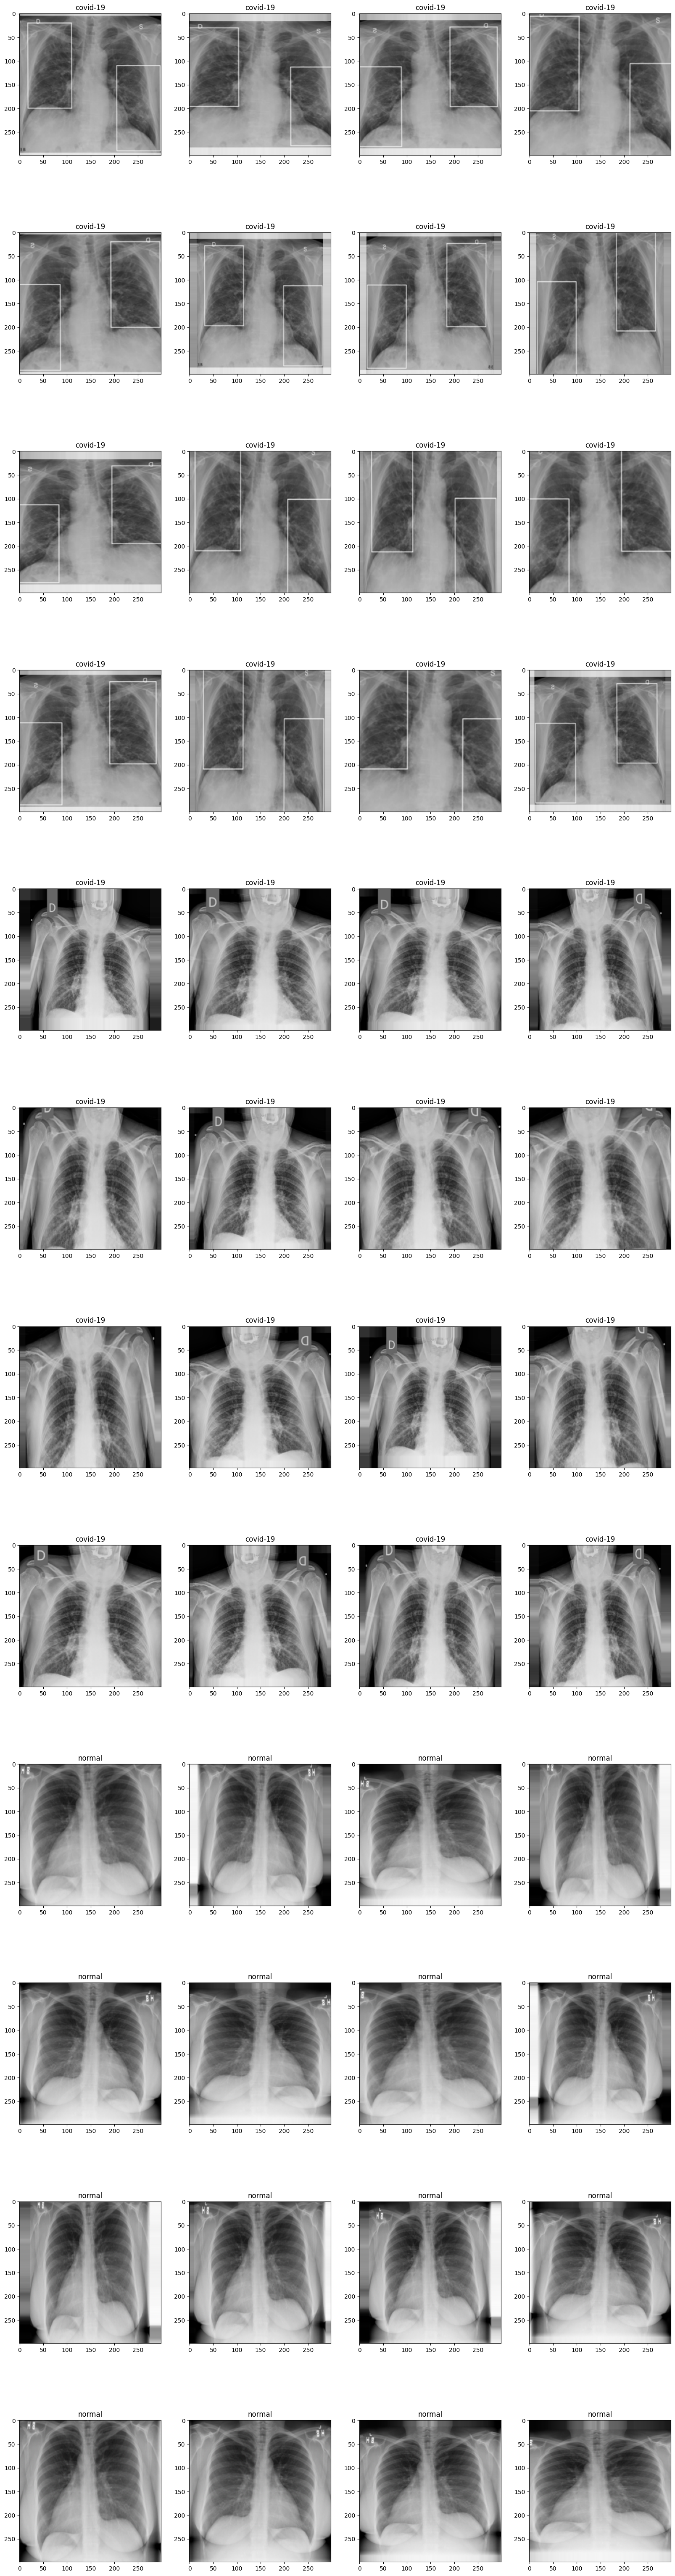

In [ ]:
images = [train[34][0][0] for i in range(16)]
images = images + [train[5][0][0] for i in range(16)]
images = images + [train[0][0][0] for i in range(16)]

labels=[]
labels = [train[34][1][0] for i in range(16)]
labels=  labels + [train[5][1][0] for i in range(16)]
labels=  labels + [train[0][1][0] for i in range(16)]

plotImages(images,labels)

In [20]:
model = Sequential()
model.add(Input(shape =(299,299,3)))
model.add(base)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dropout (Dropout)           (None, 10, 10, 2048)      0         
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dropout_1 (Dropout)         (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 16)                3276816   
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 24138347 (92.08 MB)
Trainable params: 3276

In [26]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit_generator(train,epochs=15,validation_data=val)

model.save('xception.h5')
model.save('xception.keras')

<ipython-input-26-ab11b1a01f11>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train,epochs=15,validation_data=val)


Epoch 1/15
356/356 [==============================] - 436s 1s/step - loss: 0.4384 - accuracy: 0.9107 - val_loss: 0.6366 - val_accuracy: 0.9234
Epoch 2/15
356/356 [==============================] - 369s 1s/step - loss: 0.3093 - accuracy: 0.9243 - val_loss: 0.2760 - val_accuracy: 0.9345
Epoch 3/15
356/356 [==============================] - 366s 1s/step - loss: 0.2148 - accuracy: 0.9341 - val_loss: 0.2849 - val_accuracy: 0.9266
Epoch 4/15
356/356 [==============================] - 415s 1s/step - loss: 0.2023 - accuracy: 0.9337 - val_loss: 0.2317 - val_accuracy: 0.9359
Epoch 5/15
356/356 [==============================] - 363s 1s/step - loss: 0.1789 - accuracy: 0.9356 - val_loss: 0.2039 - val_accuracy: 0.9369
Epoch 6/15
356/356 [==============================] - 365s 1s/step - loss: 0.1584 - accuracy: 0.9433 - val_loss: 0.1991 - val_accuracy: 0.9390
Epoch 7/15
356/356 [==============================] - 364s 1s/step - loss: 0.1418 - accuracy: 0.9482 - val_loss: 0.1861 - val_accuracy: 0.9417

In [27]:
test_loss, test_accuracy = model.evaluate(val)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

119/119 [==============================] - 92s 770ms/step - loss: 0.1960 - accuracy: 0.9356
Test Accuracy: 93.56%
